### Organizing the gene data
- Get landmark gene list
- Get big mechanism interactions that are in landmark gene list

In [3]:
    landmark = pd.read_table('/project/ishanu/LINCS/data/metadata/landmark_genes.txt','\t',index_col=0)

In [24]:
landmark.loc[landmark['pr_gene_symbol'].isin(['TP53','PTEN','HIF1A','TBP','EGF']),:]

,basex_affx,basex_rnaseq,copy_number,ds_index,is_bing,is_expressed,is_l1000,is_lm,pr_gene_id,pr_gene_symbol,pr_gene_title,pr_id,pr_pool_id
153,"{u'U266': 11.1, u'CL34': 12.67, u'OV7': 14.07,...","{u'CL34': 5.25, u'OV7': 7.32, u'HS578T': 6.81,...","{u'CL34': 0.15000000596046448, u'OV7': 0.11999...",41,True,"{u'U266': True, u'CL34': True, u'OV7': True, u...",True,True,3091,HIF1A,"hypoxia inducible factor 1, alpha subunit (bas...",200989_at,[u'epsilon']
489,"{u'U266': 4.23, u'CL34': 6.01, u'OV7': 4.24, u...","{u'CL34': 1.59, u'OV7': 0.05, u'HS578T': 0.42,...","{u'CL34': -0.05000000074505806, u'OV7': -0.740...",13,True,"{u'U266': False, u'CL34': True, u'OV7': False,...",True,True,1950,EGF,epidermal growth factor,206254_at,[u'epsilon']
816,"{u'U266': 11, u'CL34': 10.24, u'OV7': 8.31, u'...","{u'CL34': 3.5, u'OV7': 2.03, u'HS578T': 2.46, ...","{u'CL34': 0.10999999940395355, u'OV7': -0.7599...",1134,True,"{u'U266': True, u'CL34': True, u'OV7': True, u...",True,True,5728,PTEN,phosphatase and tensin homolog,204054_at,[u'deltap']
18,"{u'U266': 7.25, u'CL34': 7.14, u'OV7': 7.61, u...","{u'CL34': 3.59, u'OV7': 3.54, u'HS578T': 2.54,...","{u'CL34': 0.18000000715255737, u'OV7': 0.12999...",18,True,"{u'U266': True, u'CL34': True, u'OV7': True, u...",True,True,6908,TBP,TATA box binding protein,203135_at,[u'epsilon']
73,"{u'U266': 6.48, u'CL34': 9.65, u'OV7': 7.77, u...","{u'CL34': 5.58, u'OV7': 3.99, u'HS578T': 4.12,...","{u'CL34': 0.05000000074505806, u'OV7': -0.8399...",81,True,"{u'U266': True, u'CL34': True, u'OV7': True, u...",True,True,7157,TP53,tumor protein p53,201746_at,[u'epsilon']


Get the interactions from Gengjie, and take the ones that involve landmark genes & have highest certainty value.  For this notebook I did edge:  TP53 -> HIF1A

In [2]:
ixns = pd.read_table('results_corrected_1_to_3923_gene_expression.txt',sep='\t')
ixns.loc[(ixns['corrected_upstream'].isin(landmark['pr_gene_symbol']) & 
          ixns['corrected_downstream'].isin(landmark['pr_gene_symbol'])),:].iloc[:5,:].transpose() 
#.sort_values('corrected_certainty_semantic_type').iloc[:5,:]

,4,9,10,18,19
intId,657,1367,1386,2849,3422
corrected_upstream,TP53,PTEN,TP53,EGF,SRC
corrected_regulation_type,activation,inhibition,activation,activation,activation
corrected_certainty_semantic_type,0.8,0.8,0.8,0.8,0.8
corrected_interaction_effect,controls-expression-of,controls-expression-of,controls-expression-of,controls-expression-of,regulates-transcription-of
corrected_certainty_molecular_mechanism,0.8,0.8,0.8,0.8,0.8
corrected_downstream,HIF1A,HIF1A,PTEN,TBP,EGFR


### Organizing the experiment data
Now, get the experiments on cell line MCF7 with "gold" status = highly reproducible

In [1]:
import cmap.util.api_utils as apiu
ac = apiu.APIContainer(key='94b0e0816bd3cad761ad29c43b193879')

ngold = ac.siginfo.find({'is_gold':True,'cell_id':'MCF7'}, count= True)
hb = ac.siginfo.find({'is_gold':True,'cell_id':'MCF7'},
                        toDataFrame = True, limit = 1)
csel = ['distil_id','pert_id','pert_iname','sig_id']
goldmcf = pd.DataFrame(np.zeros((0,len(csel)) ), columns=csel)
skipnum = 0
while skipnum <= ngold:
    cp = ac.siginfo.find({'is_gold':True,'cell_id':'MCF7'}, toDataFrame = True, 
                          limit = 1000, skip = skipnum).loc[:,csel]
    #print 'at skip ', skipnum, ' got ', cp.shape[0]
    goldmcf = pd.concat((goldmcf, cp)) #.iloc[skipnum:(skipnum + cp.shape[0]), :] = cp
    skipnum += 1000
goldmcf.to_pickle('gold_mcf7.pkl')

32024 records match query, but the limit is 1.
First 1 entries will be returned.

32024 records match query, but the limit is 1000.
First 1000 entries will be returned.

32024 records match query, but the limit is 1000.
First 1000 entries will be returned.

32024 records match query, but the limit is 1000.
First 1000 entries will be returned.

32024 records match query, but the limit is 1000.
First 1000 entries will be returned.

32024 records match query, but the limit is 1000.
First 1000 entries will be returned.

32024 records match query, but the limit is 1000.
First 1000 entries will be returned.

32024 records match query, but the limit is 1000.
First 1000 entries will be returned.

32024 records match query, but the limit is 1000.
First 1000 entries will be returned.

32024 records match query, but the limit is 1000.
First 1000 entries will be returned.

32024 records match query, but the limit is 1000.
First 1000 entries will be returned.

32024 records match query, but the lim

In [9]:
goldmcf.iloc[:5,:].transpose()

,0,1,2,3,4
brew_prefix,[CPC020_MCF7_24H],[CPC020_MCF7_24H],[CPC020_MCF7_24H],[CPC020_MCF7_24H],[CPC020_MCF7_24H]
cell_id,MCF7,MCF7,MCF7,MCF7,MCF7
cgs_vs_sister_cc,NaN,NaN,NaN,NaN,NaN
distil_cc_pw,NaN,NaN,NaN,NaN,NaN
distil_cc_q75,0.48,0.32,0.31,0.35,0.38
distil_id,"[CPC020_MCF7_24H_X1_F1B4_DUO52HI53LO:A11, CPC0...","[CPC020_MCF7_24H_X1_F1B4_DUO52HI53LO:E17, CPC0...","[CPC020_MCF7_24H_X1_F1B4_DUO52HI53LO:E18, CPC0...","[CPC020_MCF7_24H_X1_F1B4_DUO52HI53LO:G19, CPC0...","[CPC020_MCF7_24H_X1_F1B4_DUO52HI53LO:C05, CPC0..."
distil_nrep,NaN,NaN,NaN,NaN,NaN
distil_nsample,5,5,5,5,5
distil_pert_id,NaN,NaN,NaN,NaN,NaN
distil_ss,5.10488,3.24332,2.88853,3.17437,3.42053


In [1]:
goldmcf = pd.read_pickle('gold_mcf7.pkl')

Then, use this to get "distil_id" = identify of which experiments we want, load in the expression info for the experiments, and only the landmark genes:

In [20]:
from itertools import chain
distils = list(chain.from_iterable(list(goldmcf['distil_id'])))
distils = [d for d in distils if not '-666' in d]

import numpy as np
ddo = np.random.choice(distils, size=10000,replace=False)

import cmap.io.gct as gct
import cmap.io.plategrp as grp
i = 0
df = pd.DataFrame()
while i < len(ddo):
    GCTObject = gct.GCT('/project/ishanu/LINCS/data/level4/zspc_n1328098x22268.gctx')
    GCTObject.read(cid=list(ddo[i:(i+1000)]),
                rid=list(land['pr_id'])) 
    if df.shape[0] == 0:
        df = pd.DataFrame(GCTObject.matrix,
                            index = GCTObject.get_row_meta('id'),
                             columns = GCTObject.get_column_meta('id'))
    else:
        df = pd.concat((df, pd.DataFrame(GCTObject.matrix,
                            index = GCTObject.get_row_meta('id'),
                             columns = GCTObject.get_column_meta('id'))),axis=1)
    i += 1000
df.to_pickle('mcfrand.pkl')   

In [6]:
def get_probe(gene):
    return landmark.loc[landmark['pr_gene_symbol']==gene,'pr_id'].values[0]

Show that the genes in our edge-list have normalish distributions

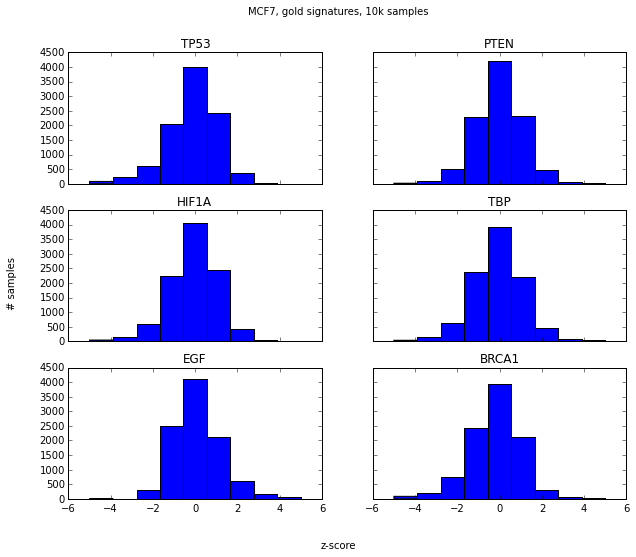

In [69]:
genes = ['TP53','PTEN','HIF1A','TBP','EGF','BRCA1']
f, ax = plt.subplots(3,2,sharex=True,sharey=True,figsize=(10,8))
ax = list(chain.from_iterable(ax))
for i in range(len(genes)):
    ax[i].hist(df.loc[get_probe(genes[i]),:],bins=np.linspace(-5,5,10))
    ax[i].set_title(genes[i])
f.text(0.5, 0.04, 'z-score', ha='center')
f.text(0.04, 0.5, '# samples', va='center', rotation='vertical')
f.suptitle('MCF7, gold signatures, 10k samples')

### Now run SVMs:
I did 5 fold train/test splits.  For a triplet {fromGene, toGene, randGene}, I trained/tested each fold 3 ways:

1. **withheld**: witholding `{fromGene, toGene, randGene}`
2. **fromIn**: withholding `{toGene, randGene}`
3. **randIn**: witholding `{fromGene, toGene}`
    
For each  fold, for each of these subsets, I train on and predict "toGene" labels.  I get the cross-classification of true labels (L0/L1), predicted labels (P0/P1), and then calculate $F1 = {{2*(precision*recall)} \over {precision + recall } }$

In [2]:
df = pd.read_pickle('mcfrand.pkl')   

In [17]:
def pr_f1(pred, lab):
    ct = np.array(pd.crosstab(pred,lab ))
    precision = ct[1,1]/float(ct[1,:].sum())
    recall =  ct[1,1]/float(ct[:,1].sum())
    return (2*(precision*recall)/(precision + recall), 
            pd.DataFrame(ct,index=['P0','P1'],columns=['L0','L1']))

def dosvm(drops, train_index, test_index):
    clf.fit( df.drop(drops,axis=0).iloc[:,train_index].transpose(), 
                label[train_index])
    pred = clf.predict(df.drop(drops,axis=0).iloc[:,test_index].transpose())
    return pr_f1(pred, label[test_index])


In [49]:
from sklearn.model_selection import StratifiedKFold
from sklearn import svm
fromGene = 'TP53'
toGene = 'HIF1A'
#randGene = np.random.choice(list(set(landmark['pr_gene_symbol'])-set([fromGene,toGene])),1)[0]
cut = 1
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits,random_state=0)
fromProbe = get_probe(fromGene)
toProbe = get_probe(toGene)
randProbe = get_probe(randGene)
label = (df.loc[toProbe,:] > cut).map(int)       
n_samples = df.shape[1]

cdo = 1
i = 0
res = pd.DataFrame(0, index=range(n_splits),columns=['withheld','fromIn','randIn'])
for train_index, test_index in skf.split(np.zeros(n_samples), label):
    clf = svm.SVC(class_weight='balanced',C=cdo)
    
    sc0 = dosvm([fromProbe,toProbe,randProbe], train_index, test_index)
    res.loc[i,'withheld'] = sc0[0]
    
    sc1 = dosvm([toProbe,randProbe], train_index, test_index)
    res.loc[i,'fromIn'] = sc1[0]
    
    sc2 = dosvm([toProbe,fromProbe], train_index, test_index)
    res.loc[i,'randIn'] = sc2[0]
    print pd.concat({'withheld':sc0[1], 'fromIn':sc1[1], 'randIn':sc2[1]},axis=1)
    i += 1
print res

   fromIn      randIn      withheld     
       L0   L1     L0   L1       L0   L1
P0   1688  296   1686  296     1688  296
P1      5   12      7   12        5   12
   fromIn      randIn      withheld     
       L0   L1     L0   L1       L0   L1
P0   1680  283   1680  283     1680  283
P1     13   25     13   25       13   25
   fromIn      randIn      withheld     
       L0   L1     L0   L1       L0   L1
P0   1680  289   1680  289     1680  289
P1     13   18     13   18       13   18
   fromIn      randIn      withheld     
       L0   L1     L0   L1       L0   L1
P0   1677  292   1677  294     1678  292
P1     15   15     15   13       14   15
   fromIn      randIn      withheld     
       L0   L1     L0   L1       L0   L1
P0   1679  287   1679  287     1679  287
P1     13   20     13   20       13   20
   withheld    fromIn    randIn
0  0.073846  0.073846  0.073394
1  0.144509  0.144509  0.144509
2  0.106509  0.106509  0.106509
3  0.089286  0.089021  0.077612
4  0.117647  0.11764

Results.. so far, nothing promising, but I will do more tests

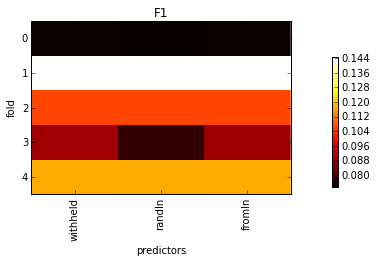

In [58]:
f = plt.figure()
axmatrix = f.add_axes([0.09,.1,.6,.6]) #imgbottom,imgwidth,imgheight])
res = res.loc[:,['withheld','randIn','fromIn']]
cax = axmatrix.imshow(res, #yidx
                      cmap='hot',vmin=res.min().min(), vmax = res.max().max(), #-1*absmax, vmax=absmax,
                      interpolation='none', aspect = 'auto')

axmatrix.set_xticks(range(res.shape[1]))
axmatrix.set_yticks(range(res.shape[0]))
axmatrix.set_xticklabels(res.columns,rotation=90)
axmatrix.set_yticklabels(res.index) 
axmatrix.set_ylabel('fold')
axmatrix.set_xlabel('predictors')
axcbar = f.add_axes([0.7 ,0.05,0.1,0.6])
axcbar.set_xticks([])
axcbar.set_yticks([])
axcbar.set_axis_off()
cbar = f.colorbar(cax, ax=axcbar) #rientation='horizontal',
axmatrix.set_title('F1')

### Scraps

In [35]:
from scipy import stats
from collections import Counter
%matplotlib inline
import matplotlib.pyplot as plt

In [57]:
## choosing C paraameter

cdo = np.logspace(-2,2,5)
f1s2 = np.zeros(len(cdo))
for c in range(len(cdo)):
    clf = svm.SVC(class_weight='balanced',C=cdo[c])
    clf.fit( df.drop([fromProbe,toProbe],axis=0).iloc[:,train_index].transpose(), 
                label[train_index])
    pred = clf.predict(df.drop([fromProbe,toProbe],axis=0).iloc[:,test_index].transpose())
    if pred.sum()==0:
        f1s2[c] = 0
        continue

print f1s2

[ 0.          0.2892562   0.06585366  0.03535354  0.03535354]


In [3]:
import cmap.util.api_utils as apiu
ac = apiu.APIContainer(key='94b0e0816bd3cad761ad29c43b193879')
num_cps = ac.cellinfo.find({'cell_type':'cancer'}, count= True)

hb = ac.cellinfo.find({'cell_type':'cancer'},
                        toDataFrame = True, limit = 1)
celldf = pd.DataFrame(np.zeros((0, hb.shape[1])), columns=hb.columns)
skipnum = 0
while skipnum <= celldf:
    cp = ac.cellinfo.find({'cell_type':'cancer'}, toDataFrame = True, 
                          limit = 1000, skip = skipnum)
    print 'at skip ', skipnum, ' got ', cp.shape[0]
    celldf = pd.concat((celldf, cp)) #.iloc[skipnum:(skipnum + cp.shape[0]), :] = cp
    skipnum += 1000
    

1008 records match query, but the limit is 1.
First 1 entries will be returned.

1008 records match query, but the limit is 1000.
First 1000 entries will be returned.

at skip  0  got  1000
1008 records match query, but the limit is 1000.
First 1000 entries will be returned.

at skip  1000  got  8
1008 records match query, but the limit is 1000.
First 1000 entries will be returned.

at skip  2000  got  0
1008 records match query, but the limit is 1000.
First 1000 entries will be returned.

at skip  3000  got  0
1008 records match query, but the limit is 1000.
First 1000 entries will be returned.

at skip  4000  got  0


In [6]:
celldf.iloc[:5,:].transpose()

,0,1,2,3,4
cell_aliases,1321N1,-666,SNG-M,SK-MEL-28,HT115
cell_histology,"glioma,astrocytoma",osteosarcoma,carcinoma,melanoma,carcinoma
cell_id,1321N1,143B,SNGM,SKMEL28,HT115
cell_lineage,CNS,bone,"endometrium,uterus",skin,"large intestine,colon"
cell_source,ECACC,ATCC,HSRRB,ATCC,ECACC
cell_source_id,-666,CRL-8303,-666,HTB-72,-666
cell_type,cancer,cancer,cancer,cancer,cancer
gender,M,F,F,M,-666
is_from_metastasis,N,-666,-666,-666,N
lincs_status,NaN,NaN,[DIVR],[DIVR],[DIVR]


In [25]:
from scipy import stats

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [1]:
cp_df = pd.read_pickle('cp_df.pkl')